# Datathon Henry

## Exploratory data analysis

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans

In [2]:
X = pd.read_csv('datasets/properties_colombia_train.csv')
X.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry
0,861131,CScTjaFiP6yCzS8tFX0ZVA==,Propiedad,2020-12-14,9999-12-31,2020-12-14,6.203000,-75.572000,Colombia,Antioquia,...,NaN,NaN,9.000000e+09,COP,NaN,Hermosa Mansión En El Poblado. Área Construida...,<b>Hermosa Mansión En El Poblado. Área Constru...,Casa,Venta,POINT (-75.572 6.203)
1,200972,DlCxox9+FuugkxS2kBVfJg==,Propiedad,2020-09-16,2021-05-14,2020-09-16,4.722748,-74.073115,Colombia,Cundinamarca,...,NaN,NaN,6.250000e+08,COP,NaN,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE",Venta apartamento en piso 16 con vista exterio...,Apartamento,Venta,POINT (-74.0731146 4.7227485)
2,554622,yitN1AigL45gh/K2YSF8rw==,Propiedad,2020-08-19,2020-08-20,2020-08-19,4.709000,-74.030000,Colombia,Cundinamarca,...,NaN,NaN,4.200000e+08,COP,NaN,Apartamento En Venta En Bogota Bella Suiza Cod...,Al entrar a este bonito apartamento interior e...,Casa,Venta,POINT (-74.03 4.709)
3,540321,hELQ9njwODbLMpATXieRdQ==,Propiedad,2020-11-23,2020-11-30,2020-11-23,NaN,NaN,Colombia,Santander,...,NaN,NaN,1.310000e+09,COP,NaN,SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...,Se encuentra ubicado en el sector de la Cabece...,Otro,Venta,POINT EMPTY
4,448920,aBCtKT7LDzt2CxJQ+gVFEA==,Propiedad,2020-10-06,2020-10-07,2020-10-06,NaN,NaN,Colombia,Antioquia,...,NaN,NaN,2.100000e+08,COP,NaN,Apartamento en Venta Ubicado en ITAGUI,Codigo Inmueble 4302 Apartamento con 3 habitac...,Apartamento,Venta,POINT EMPTY


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197549 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197549 non-null  int64  
 1   id               197549 non-null  object 
 2   ad_type          197549 non-null  object 
 3   start_date       197549 non-null  object 
 4   end_date         197549 non-null  object 
 5   created_on       197549 non-null  object 
 6   lat              148051 non-null  float64
 7   lon              148051 non-null  float64
 8   l1               197549 non-null  object 
 9   l2               197549 non-null  object 
 10  l3               186517 non-null  object 
 11  l4               45367 non-null   object 
 12  l5               27409 non-null   object 
 13  l6               6867 non-null    object 
 14  rooms            27537 non-null   float64
 15  bedrooms         40525 non-null   float64
 16  bathrooms        156467 non-null  floa

Vamos a revisar que hay en cada columna. Unnamed: 0 e id son identificadores que no son informativos para la clasificación.

Las columnas que solo tienen un tipo de dato no son de utilizada para la clasificación:

In [4]:
# aqui notamos además que id y unnamed: 0 no tiene repetidos
X.nunique()

Unnamed: 0         197549
id                 197549
ad_type                 1
start_date            145
end_date              446
created_on            145
lat                 51077
lon                 50108
l1                      1
l2                     31
l3                    293
l4                     58
l5                     20
l6                    146
rooms                  29
bedrooms               37
bathrooms              20
surface_total        1035
surface_covered       783
price                6096
currency                2
price_period            1
title               95025
description        111371
property_type           8
operation_type          1
geometry            62807
dtype: int64

In [5]:
for column in X.columns.tolist():
    if len(X[column].unique()) <= 2:
        print(column,': ', X[column].unique())

ad_type :  ['Propiedad']
l1 :  ['Colombia']
price_period :  [nan 'Mensual']
operation_type :  ['Venta']


`created_on` y `start_date` son la misma columna:

In [6]:
(X.created_on != X.start_date).sum()

0

`geometry` es la latitud y la longitud en una sola columna.

In [7]:
X[['geometry', 'lat', 'lon']].head()

,geometry,lat,lon
0,POINT (-75.572 6.203),6.203000,-75.572000
1,POINT (-74.0731146 4.7227485),4.722748,-74.073115
2,POINT (-74.03 4.709),4.709000,-74.030000
3,POINT EMPTY,NaN,NaN
4,POINT EMPTY,NaN,NaN


De acuerdo a lo anterior, eliminamos: `Unnamed: 0`, `id`, `ad_type`, `l1`, `price_period`, `operation_type`, `created_on`, `geometry`

In [8]:
X.drop(['Unnamed: 0', 'id', 'ad_type', 'l1', 'price_period', 'operation_type', 'created_on', 'geometry'], axis='columns', inplace=True)

In [9]:
X.columns

Index(['start_date', 'end_date', 'lat', 'lon', 'l2', 'l3', 'l4', 'l5', 'l6',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type'],
      dtype='object')

De las variables que quedaron, start_date, end_date, lat, lon, l2, l3, l4, l5, l6, title, description, property_type son variables cualitativas y rooms, bedrooms, bathrooms, surface_total, surface_covered, price son cuantitativas. Ahora, revisemos valores faltantes:

In [10]:
# porcentaje de nulos
X.isnull().mean()*100

start_date          0.000000
end_date            0.000000
lat                25.056062
lon                25.056062
l2                  0.000000
l3                  5.584437
l4                 77.035065
l5                 86.125468
l6                 96.523900
rooms              86.060674
bedrooms           79.486102
bathrooms          20.795853
surface_total      96.469737
surface_covered    95.038193
price               0.031891
currency            0.033916
title               0.000506
description         0.061251
property_type       0.000000
dtype: float64

Las variables cuantitativas tienen un alto porcentaje de faltantes. Tambien l4 y l5, que son variables relacionadas a la ubicación. Nos quedaremos con dos niveles administrativos por ahora, l2 y l3

In [11]:
X.drop(['l4','l5','l6'], axis='columns',inplace=True)
X.columns

Index(['start_date', 'end_date', 'lat', 'lon', 'l2', 'l3', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'price', 'currency',
       'title', 'description', 'property_type'],
      dtype='object')

Para graficar separando por categoria, hay que normalizar la variable de precio. Primero, cambiamos la variable de precios que esté en USD a COP. El cambio a usar va a ser por fecha. El precio promedio del COP en USD en 2020, que es el único año para el que tenemos datos, fue de 3691.3167 COP = 1 USD.

In [12]:
X.loc[X.currency == 'USD', 'price'] = X.price*3691.3167

Podemos eliminar currency

In [13]:
X.drop(['currency'], axis='columns', inplace=True)

Ahora vamos a visualizar la distribución de precios

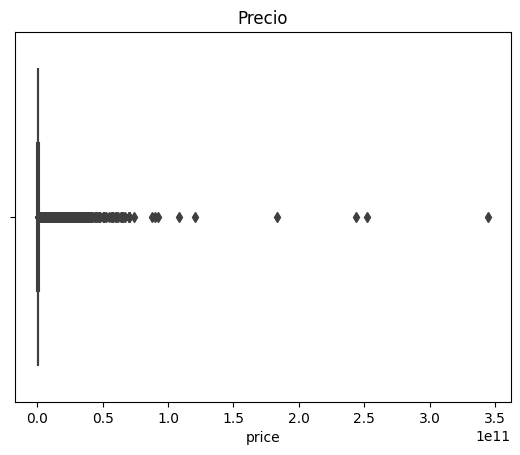

In [21]:
sns.boxplot(data=X, x='price')
plt.title('Precio');

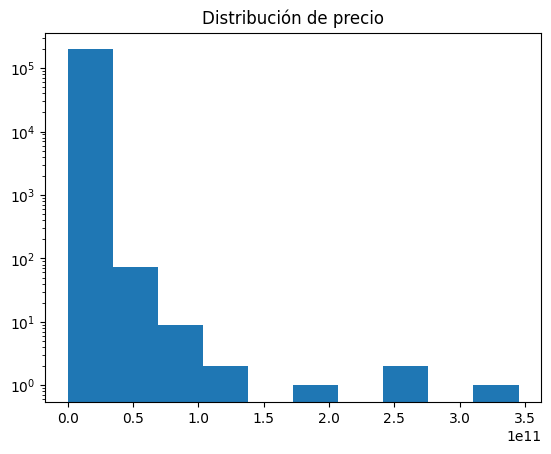

In [22]:
plt.hist(X.price, log=True)
plt.title('Distribución de precio');

In [ ]:
'''
# eliminamos outliers
q1 = X.price.quantile(.25)
q3 = X.price.quantile(.75)
iqr = q3-q1

lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

filter = (X.price >= lower) & (X.price <= upper) | (X.price.isnull())

X = X.loc[filter]
X.shape
'''

(178224, 15)

Rellenamos los precios nulos con la media, ya que no queremos que se altere porque es lo que vamos a usar para clasificar.

In [23]:
X.loc[X.price.isnull(), 'price'] = X.price.mean()
# Vemos que no hay nulos
X.price.isnull().sum() 

0

Ahora revisaremos los outliers de latitud y longitud.

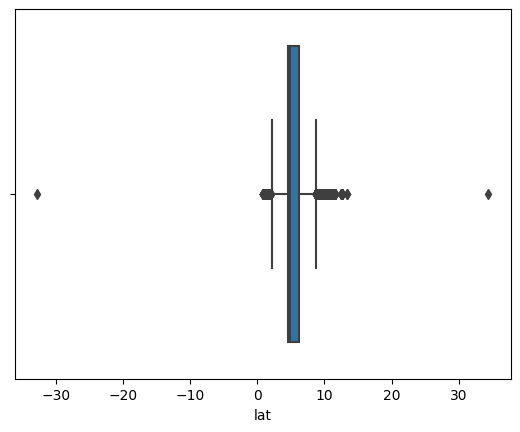

In [24]:
sns.boxplot(data=X, x='lat');

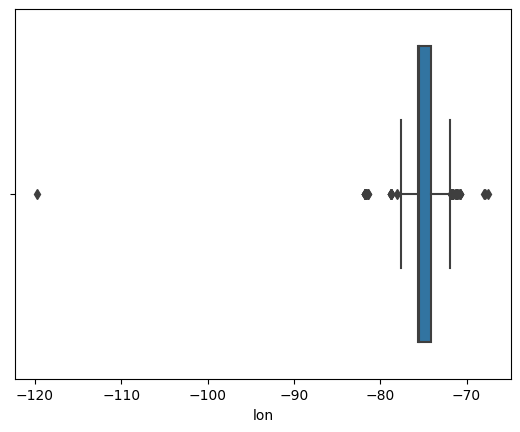

In [25]:
sns.boxplot(data=X, x='lon');

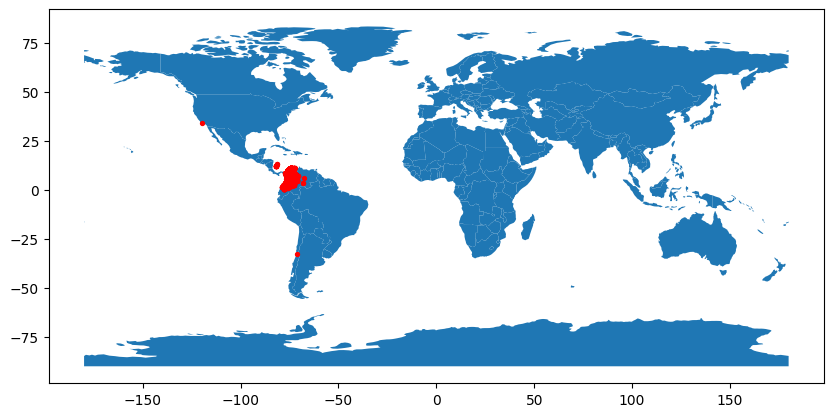

In [26]:
geometry = [Point(xy) for xy in zip(X['lon'], X['lat'])]
gdf = GeoDataFrame(X, geometry=geometry)    

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=8);

Vemos al menos 2 punto que se encuentra fuera de Colombia.

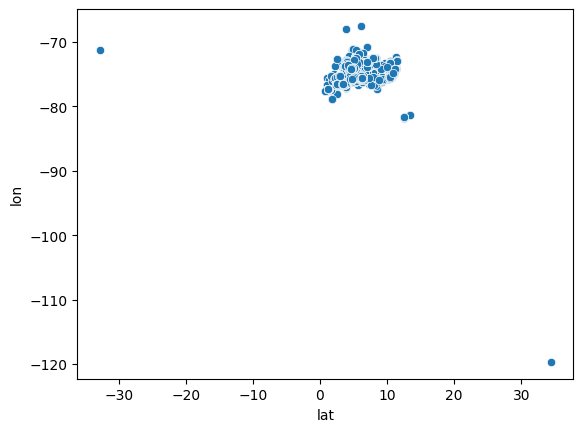

In [27]:
sns.scatterplot(data=X, x='lat', y='lon');

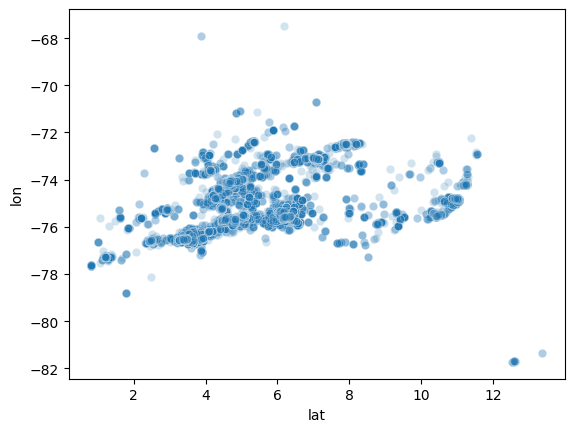

In [28]:
# eliminamos el registo que es evidentemente un outlier (punto en USA en el plot de mapa)
X = X.loc[~(X.lat > 30)]
X = X.loc[~(X.lat < -20)]
# ahora la correlacion 
sns.scatterplot(data=X, x='lat', y='lon', alpha=0.2);

Los otros puntos que parecen outliers sí se encuentran en Colombia. Veamos los valores faltantes en latitud y longitud

In [29]:
X.isnull().sum()

start_date              0
end_date                0
lat                 49498
lon                 49498
l2                      0
l3                  11032
rooms              170012
bedrooms           157022
bathrooms           41082
surface_total      190573
surface_covered    187745
price                   0
title                   1
description           121
property_type           0
geometry                0
dtype: int64

In [30]:
X.loc[X.lat.isnull()].l2.unique()

array(['Santander', 'Antioquia', 'Atlántico', 'Córdoba', 'Cundinamarca',
       'Meta', 'Valle del Cauca', 'Caldas', 'Risaralda', 'Magdalena',
       'Cauca', 'Huila', 'Bolívar', 'Tolima', 'Norte de Santander',
       'Quindío', 'Caquetá', 'Sucre', 'Boyacá', 'Guainía', 'La Guajira',
       'Cesar', 'Amazonas', 'San Andrés Providencia y Santa Catalina',
       'Casanare', 'Vichada', 'Chocó'], dtype=object)

Creamos una función para rellenar las latitudes y longitudes faltantes:

In [31]:
def fill_lat_lon(df):

    dict_lat = {
    'Antioquia': 7.154030, 'Atlántico': 10.987760, 'Cundinamarca': 4.781800,
    'Meta': 3.2720, 'Valle del Cauca': 3.858560, 'Caldas': 6.090000,
    'Risaralda': 4.606880, 'Magdalena': 10.249170, 'Santander': -0.622170,
    'Cauca': 8.252500, 'Huila': 3.376450, 'Bolívar': 1.833650, 'Tolima': 4.034880,
    'Norte de Santander': 8.084580, 'Quindío': 4.396070, 'Caquetá': 1.113340,
    'Sucre': 8.811250, 'Guainía': 2.719020, 'La Guajira': 11.427780,
    'Boyacá': 5.453740, 'Cesar': 10.769930, 'Amazonas': -2.056290,
    'San Andrés Providencia y Santa Catalina': 12.542720, 'Casanare': 5.296580,
    'Vichada': 4.712170, 'Córdoba': 9.586680, 'Chocó': 6.320330
    }

    dict_lon = {
    'Antioquia': -75.503349, 'Atlántico': -74.954620, 'Cundinamarca': -73.970757,
    'Meta': -73.0877, 'Valle del Cauca': -76.519810, 'Caldas': -75.636627,
    'Risaralda': -74.071840, 'Magdalena': -74.261080, 'Santander': -72.382812,
    'Cauca': -74.722893, 'Huila': -74.802391, 'Bolívar': -76.967293, 'Tolima': -75.255890, 
    'Norte de Santander': -72.842781, 'Quindío': -75.640083, 'Caquetá': -73.813004, 
    'Sucre': -74.721390, 'Guainía': -67.566940, 'La Guajira': -72.388634,
    'Boyacá': -73.362480, 'Cesar': -73.004791, 'Amazonas': -71.892921,
    'San Andrés Providencia y Santa Catalina': -81.717900, 'Casanare': -71.456268,
    'Vichada': -69.414350, 'Córdoba': -74.826302, 'Chocó': -76.944901
    }
    df.lat = np.where(df.lat.isnull(), df.l2.map(dict_lat), df.lat)
    df.lon = np.where(df.lon.isnull(), df.l2.map(dict_lon), df.lon)

    return None

Rellenamos valores faltantes utilizando los diccionarios asociados a l2.

In [32]:
fill_lat_lon(X)
# Vemos que no hay nulos en lat y lon
X[['lat','lon']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197547 entries, 0 to 197548
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     197547 non-null  float64
 1   lon     197547 non-null  float64
dtypes: float64(2)
memory usage: 4.5 MB


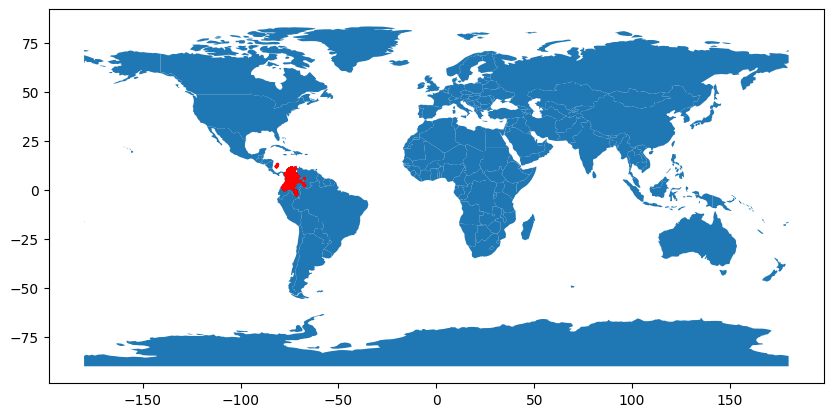

In [33]:
geometry = [Point(xy) for xy in zip(X['lon'], X['lat'])]
gdf = GeoDataFrame(X, geometry=geometry)    

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=2);

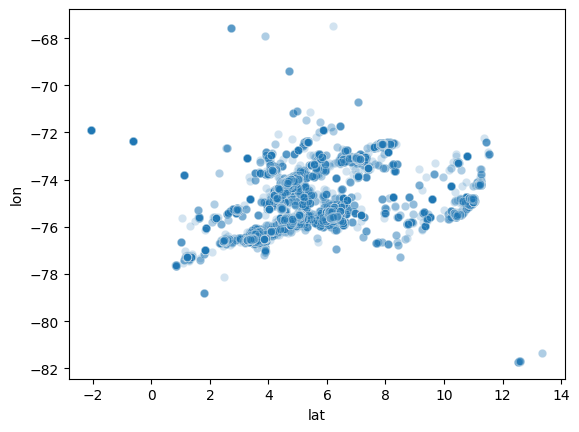

In [34]:
sns.scatterplot(data=X, x='lat', y='lon', alpha=0.2);

Ahora procesamos las fechas

In [35]:
X.start_date = pd.to_datetime(X.start_date)
max_month = X.start_date.dt.month.max()
min_month = X.start_date.dt.month.min()
print('Tenemos registros de 2020 desde el mes {} hasta el mes {}'.format(min_month, max_month))

Tenemos registros de 2020 desde el mes 7 hasta el mes 12


In [36]:
# Se podría calcular los dias que estuvo activa la publicación
X.end_date = pd.to_datetime(X.end_date, errors='coerce')
X['ad_time'] = X.end_date - X.start_date
X['ad_time'] = X['ad_time'].dt.days

In [37]:
# Rellenamos los faltantes, que son los que no se han vendido (?)
X.loc[X.ad_time.isnull(),'ad_time'] = 9999
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197547 entries, 0 to 197548
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   start_date       197547 non-null  datetime64[ns]
 1   end_date         185573 non-null  datetime64[ns]
 2   lat              197547 non-null  float64       
 3   lon              197547 non-null  float64       
 4   l2               197547 non-null  object        
 5   l3               186515 non-null  object        
 6   rooms            27535 non-null   float64       
 7   bedrooms         40525 non-null   float64       
 8   bathrooms        156465 non-null  float64       
 9   surface_total    6974 non-null    float64       
 10  surface_covered  9802 non-null    float64       
 11  price            197547 non-null  float64       
 12  title            197546 non-null  object        
 13  description      197426 non-null  object        
 14  property_type    197

De la fecha de inicio podemos extraer el mes

In [38]:
X['month_start'] = X.start_date.dt.month
X.drop(['start_date','end_date'], axis='columns', inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197547 entries, 0 to 197548
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   lat              197547 non-null  float64 
 1   lon              197547 non-null  float64 
 2   l2               197547 non-null  object  
 3   l3               186515 non-null  object  
 4   rooms            27535 non-null   float64 
 5   bedrooms         40525 non-null   float64 
 6   bathrooms        156465 non-null  float64 
 7   surface_total    6974 non-null    float64 
 8   surface_covered  9802 non-null    float64 
 9   price            197547 non-null  float64 
 10  title            197546 non-null  object  
 11  description      197426 non-null  object  
 12  property_type    197547 non-null  object  
 13  geometry         197547 non-null  geometry
 14  ad_time          197547 non-null  float64 
 15  month_start      197547 non-null  int64   
dtypes: float64(9), geome

Revisamos la columna de title

In [39]:
# algunos titulos tienen el area total
X.title.loc[399]

'Espectacular Cabaña En Santa Helena En Parcelación. Área Total. 850m2'

In [40]:
X.loc[X.title.str.contains('Área', na=False)].title

0         Hermosa Mansión En El Poblado. Área Construida...
399       Espectacular Cabaña En Santa Helena En Parcela...
3061      Hermosos Lotes Disponibles En Condominio, Área...
3593      Vendo Apartamento Sexto Piso Área 62 m²  Rincó...
3929      Vendo Apartamento Primer Piso Área 72 m²  Caba...
                                ...                        
192837    Vendo Local Comercial Área 13 m²  Ubicado En I...
193842    Venta de Lote en Tulua vía La Rivera El Picach...
194274    Espectacular Finca - Sector Aeropuerto. Área T...
194331         Apartamento Medellín El Poblado. Área 236 m2
196929    Hermosa casa en unidad cerrada. Sector Llanogr...
Name: title, Length: 140, dtype: object

In [41]:
# formateamos str
X.title = X.title.str.capitalize().str.strip()
# eliminamos tildes
X.title = X.title.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [42]:
X.loc[X.title.str.contains('area', na=False)].title

0         Hermosa mansion en el poblado. area construida...
219       Id. 011. lote,  venta en  via potrerito-jamund...
399       Espectacular cabana en santa helena en parcela...
1724      Ideal para lotear, en venta finca en paluato a...
1756      Id. 011. lote,  venta en  via potrerito-jamund...
                                ...                        
194436      Vendo 32 hectareas en sabanalarga _ wasi1388503
195627          Venta lote 13 hectareas en km 32 via al mar
196606    Bogota santa rosa venta  bodega rentando area ...
196929    Hermosa casa en unidad cerrada. sector llanogr...
197415    Vendo local-oficina bucaramanga carrera 33 are...
Name: title, Length: 544, dtype: object

Estos datos no representan ni el 1% de datos con el área total o de construcción, por lo que se elimina esta columna.

In [43]:
X.drop(['title'], axis='columns', inplace=True)

Veamos `description`:

In [44]:
# formateamos str
X.description = X.description.str.capitalize().str.strip()
# eliminamos tildes
X.description = X.description.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [45]:
X.loc[X.description.str.contains('bano', na=False)].description.shape

(133279,)

In [46]:
searchfor = ['habitacion','cuarto','pieza']
X.loc[X.description.str.contains('|'.join(searchfor), na=False)].description.shape

(99238,)

In [47]:
searchfor = ['area']
X.loc[X.description.str.contains('|'.join(searchfor), na=False)].description.shape

(52564,)

Baños es la unica variable que vale la pena rellenar. Hago una función para obtener la cantidad de baños de la columna `description` y luego rellenar los que no hayamos obtenido con la moda por tipo de propiedad:

In [51]:
def get_number_bathrooms(df):
    # formateamos str
    df.description = df.description.str.capitalize().str.strip()
    # eliminamos tildes
    df.description = df.description.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    # Rellenamos las filas sin descripcion
    df.loc[df.description.isnull(), 'description'] = 'No description'
    
    # Cambiamos los numeros escritos por numeros
    dict_num = {' uno ': ' 1 ', ' dos ':' 2 ', ' tres ':' 3 ', ' cuatro ':' 4 ', ' cinco ':' 5 ', ' seis ':' 6 ', ' siete ':' 7 ', ' ocho ':' 8 ', ' nueve ':' 9 '}
    for old, new in dict_num.items():
        df.description = df.description.str.replace(old, new, regex=False)

    # Extraigo el numero de strings como "n banos"
    pat = f"(\d+)[\s-](?:{'bano'})"
    bathrooms = df.loc[df.bathrooms.isnull()].description.str.extract(pat)

    df = df.join(bathrooms)
    # donde hay nulos, sustituimos por el numero de baños hallado en description
    df.loc[(df.bathrooms.isnull()) & (df[0].notnull()), 'bathrooms'] = df[0]
    # revisamos que se hayan sustituido
    df.loc[(df.bathrooms.isnull()) & (df[0].notnull()), 'bathrooms']
    
    # Dropeo la columna agregada para la sustitución
    df.drop([0], axis='columns',inplace=True)

    # Rellenamos los que hayan quedado como nulos con la moda por tipo de propiedad
    moda_bath = df.groupby(['property_type']).bathrooms.agg(pd.Series.mode)
    # los parqueaderos parecen no tener baño
    moda_bath.loc['Parqueadero'] = 0

    # Sustituimos con la moda
    df.bathrooms =  np.where(df.bathrooms.isnull(), df.property_type.map(moda_bath), df.bathrooms)
    df.bathrooms = df.bathrooms.astype(int)

    return df

    

In [52]:
X = get_number_bathrooms(X)
X.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197547 entries, 0 to 197548
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   lat              197547 non-null  float64 
 1   lon              197547 non-null  float64 
 2   l2               197547 non-null  object  
 3   l3               186515 non-null  object  
 4   rooms            27535 non-null   float64 
 5   bedrooms         40525 non-null   float64 
 6   bathrooms        197547 non-null  int32   
 7   surface_total    6974 non-null    float64 
 8   surface_covered  9802 non-null    float64 
 9   price            197547 non-null  float64 
 10  description      197547 non-null  object  
 11  property_type    197547 non-null  object  
 12  geometry         197547 non-null  geometry
 13  ad_time          197547 non-null  float64 
 14  month_start      197547 non-null  int64   
dtypes: float64(8), geometry(1), int32(1), int64(1), object(4)
memory usa

Eliminamos las columnas de `rooms`, `bedrooms`, `surface_total` y `surface_covered` ya que no hay suficiente información para rellenarlas, y `description`, que ya la utilizamos.

In [53]:
X.drop(['rooms','bedrooms','surface_total','surface_covered','description'], axis='columns', inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197547 entries, 0 to 197548
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   lat            197547 non-null  float64 
 1   lon            197547 non-null  float64 
 2   l2             197547 non-null  object  
 3   l3             186515 non-null  object  
 4   bathrooms      197547 non-null  int32   
 5   price          197547 non-null  float64 
 6   property_type  197547 non-null  object  
 7   geometry       197547 non-null  geometry
 8   ad_time        197547 non-null  float64 
 9   month_start    197547 non-null  int64   
dtypes: float64(4), geometry(1), int32(1), int64(1), object(3)
memory usage: 19.9+ MB


Vamos a hacer grupos con latitud y longitud

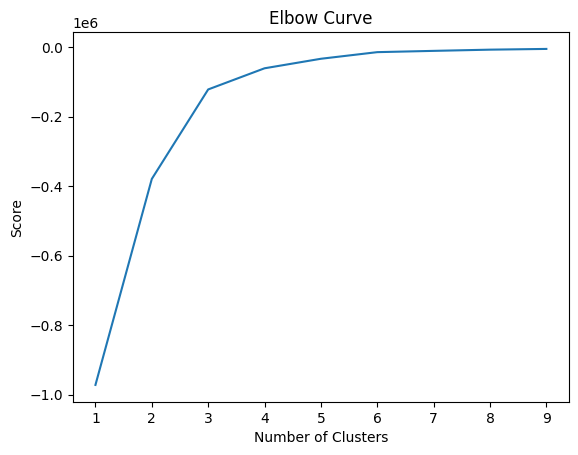

In [54]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = X[['lat']]
X_axis = X[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [55]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(X[X.columns[0:2]]) # Compute k-means clustering.
X['position_id'] = kmeans.fit_predict(X[X.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[0:2]]) # Labels of each point

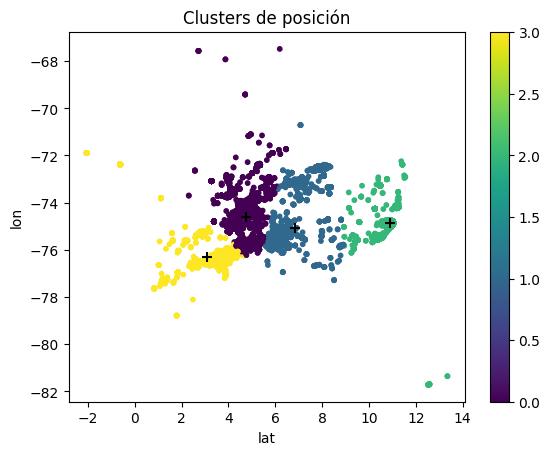

In [56]:
X.plot.scatter(x = 'lat', y = 'lon', c=labels, s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, marker='+')
plt.title('Clusters de posición');

Revisemos las correlaciones de las variables numéricas

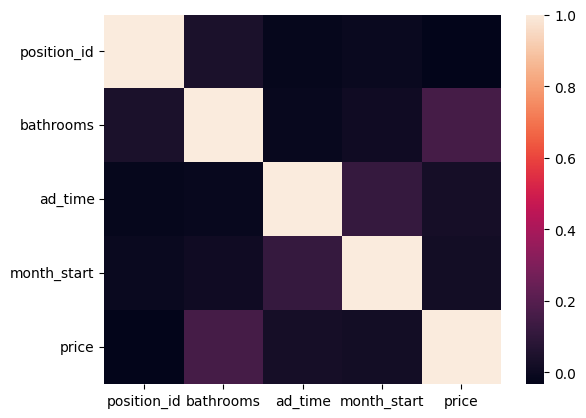

In [57]:
qlt = ['position_id', 'bathrooms', 'ad_time','month_start','price']
#correlaciones
sns.heatmap(data=X[qlt].corr());

Parece que solo el número de baños tiene correlación con la variable de precio.

## Modelo 

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score

Vemos las variables donde quedaron valores faltantes

In [93]:
X.isnull().mean()*100

lat              0.000000
lon              0.000000
l2               0.000000
l3               5.584494
bathrooms        0.000000
price            0.000000
property_type    0.000000
geometry         0.000000
ad_time          0.000000
month_start      0.000000
position_id      0.000000
dtype: float64

In [94]:
X_train = X[['lat','lon','position_id','property_type','price','month_start','bathrooms']].copy()
X_train.head()

,lat,lon,position_id,property_type,price,month_start,bathrooms
0,6.203000,-75.572000,1,Casa,9.000000e+09,12,4
1,4.722748,-74.073115,0,Apartamento,6.250000e+08,9,2
2,4.709000,-74.030000,0,Casa,4.200000e+08,8,2
3,-0.622170,-72.382812,3,Otro,1.310000e+09,11,1
4,7.154030,-75.503349,1,Apartamento,2.100000e+08,10,2


In [95]:
X_train['target'] = np.where(X_train['price']>=X_train.price.mean(), 1, 0)
X_train.head()

,lat,lon,position_id,property_type,price,month_start,bathrooms,target
0,6.203000,-75.572000,1,Casa,9.000000e+09,12,4,1
1,4.722748,-74.073115,0,Apartamento,6.250000e+08,9,2,0
2,4.709000,-74.030000,0,Casa,4.200000e+08,8,2,0
3,-0.622170,-72.382812,3,Otro,1.310000e+09,11,1,1
4,7.154030,-75.503349,1,Apartamento,2.100000e+08,10,2,0


Creamos una función para obtener los dummies de `property_type`

In [96]:
def property_type_dummies(df):
    df[['Apartamento','Casa','Finca','Local comercial','Lote','Oficina','Otro','Parqueadero']] = pd.get_dummies(df.property_type)
    df.drop('property_type',axis='columns', inplace=True)

    return None

In [97]:
property_type_dummies(X_train)
X_train[['id_1','id_2','id_3', 'id_4']] = pd.get_dummies(X_train.position_id)
X_train[['month_7','month_8','month_9', 'month_10', 'month_11', 'month_12']] = pd.get_dummies(X_train.month_start)
X_train.drop('property_type',axis='columns', inplace=True)
X_train.head()

,lat,lon,position_id,price,month_start,bathrooms,target,Apartamento,Casa,Finca,...,id_1,id_2,id_3,id_4,month_7,month_8,month_9,month_10,month_11,month_12
0,6.203000,-75.572000,1,9.000000e+09,12,4,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,4.722748,-74.073115,0,6.250000e+08,9,2,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,4.709000,-74.030000,0,4.200000e+08,8,2,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,-0.622170,-72.382812,3,1.310000e+09,11,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,7.154030,-75.503349,1,2.100000e+08,10,2,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [98]:
y_train = X_train.target
X_train = X_train[['lat', 'lon','bathrooms','Apartamento','Casa','Finca','Local comercial','Lote','Oficina','Otro','Parqueadero',]]
#X_train = X_train[['bathrooms']]
X_train.shape

(197547, 11)

In [99]:
X_train.columns

Index(['lat', 'lon', 'bathrooms', 'Apartamento', 'Casa', 'Finca',
       'Local comercial', 'Lote', 'Oficina', 'Otro', 'Parqueadero'],
      dtype='object')

In [67]:
clfs = [RandomForestClassifier(), GradientBoostingClassifier(), MLPClassifier()]

In [68]:
for clf in clfs:
    name = clf.__class__.__name__
    clf = Pipeline(steps=[('ss', StandardScaler()), ('clf', clf)])
    _scoring = ['accuracy', 'recall']
    results = cross_validate(estimator=clf,
                        X=X_train,
                        y=y_train,
                        cv=5,
                        scoring=_scoring,
                        return_train_score=True)
    print('*'*5,name,'*'*5) 
    print('accuracy: ', round(results['train_accuracy'].mean()*100,2),' ± ',round(results['train_accuracy'].std(),5))
    print('recall: ', results['train_recall'].mean()*100, ' ± ', round(results['train_recall'].std(),2))


***** RandomForestClassifier *****
accuracy:  95.66  ±  0.00026
recall:  90.54928079675697  ±  0.0
***** GradientBoostingClassifier *****
accuracy:  84.4  ±  0.00048
recall:  51.600224727193854  ±  0.0
***** MLPClassifier *****
accuracy:  83.74  ±  0.0008
recall:  52.2794077844692  ±  0.03


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [ ]:
clfs = [RandomForestClassifier(random_state=15), GradientBoostingClassifier(random_state=1), MLPClassifier(random_state=7)]

In [ ]:
'''
for clf in clfs:
    name = clf.__class__.__name__
    clf = Pipeline(steps=[('ss', StandardScaler()), ('clf', clf)])
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    print('*'*5,name,'*'*5) 
    print('accuracy: ', accuracy_score(y_test, pred))
    print('recall: ', recall_score(y_test, pred))
'''

"\nfor clf in clfs:\n    name = clf.__class__.__name__\n    clf = Pipeline(steps=[('ss', StandardScaler()), ('clf', clf)])\n    clf.fit(X_train,y_train)\n    pred = clf.predict(X_test)\n    print('*'*5,name,'*'*5) \n    print('accuracy: ', accuracy_score(y_test, pred))\n    print('recall: ', recall_score(y_test, pred))\n"

Haremos un grid search sobre el random forest, que es el que tiene mejor rendimiento.

## Predicciones
El mejor modelo fue el random forest y es el que vamos a usar para predecir. Primero, cargamos los datos de test y realizamos las transformaciones pertinentes de las columnas:

In [83]:
X_test = pd.read_csv('datasets/properties_colombia_test.csv')
X_test.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,geometry
0,852569,pCiVu6rxpBq9dCZfYCXXgA==,Propiedad,2020-09-04,2020-09-12,2020-09-04,4.722000,-74.075000,Colombia,Cundinamarca,...,3.0,660.0,350.0,COP,NaN,Casa En Arriendo/venta En Bogota Sotileza Cod....,"EXCLUSIVA CASA EN VENTA Y ARRIENDO, UBICADA EN...",Casa,Venta,POINT (-74.075 4.722)
1,121379,L0XSQ7mF1TWb1lHRg4n2+A==,Propiedad,2020-10-20,2020-10-20,2020-10-20,NaN,NaN,Colombia,Antioquia,...,3.0,NaN,NaN,COP,Mensual,SE VENDE APARTAMENTO EN EL SECTOR DE ZUÑIGA-EN...,"PR 7555. Apartamento Duplex en unidad cerrada,...",Apartamento,Venta,POINT EMPTY
2,119504,FbWRxZOMNoUzVOLXgkum1A==,Propiedad,2020-10-20,2020-10-22,2020-10-20,6.259253,-75.628381,Colombia,Antioquia,...,1.0,NaN,NaN,COP,NaN,Casa Barata San Javier Solo por este mes,"Casa compraventa escrituras en \n proceso,sala...",Casa,Venta,POINT (-75.6283806 6.25925267)
3,227304,RUV1P+3UOmNdlJ9fBdWFyw==,Propiedad,2020-12-10,9999-12-31,2020-12-10,6.203000,-75.556000,Colombia,Antioquia,...,NaN,2793.0,NaN,COP,NaN,Lote En Venta En Medellin La Calera Cod. VRPR6330,CODIGO 6330LOTE PARA LA VENTA DE 2793MTS,Lote,Venta,POINT (-75.556 6.203)
4,228600,ifKutEAhyovuDNeYrFFV+A==,Propiedad,2020-12-10,2020-12-11,2020-12-10,NaN,NaN,Colombia,Antioquia,...,2.0,NaN,NaN,COP,NaN,Casa en Venta Ubicado en MEDELLIN,Codigo Inmueble 505457 Casa en venta en el sec...,Casa,Venta,POINT EMPTY


Eliminamos las columnas que no utilizamos

In [84]:
X_test.drop(['Unnamed: 0', 'id', 'ad_type', 'start_date', 'end_date', 'created_on',
            'l1', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms',
            'surface_total', 'surface_covered', 'currency', 'price_period', 
            'title', 'operation_type', 'geometry'], axis='columns', inplace=True)

X_test.columns

Index(['lat', 'lon', 'l2', 'bathrooms', 'description', 'property_type'], dtype='object')

In [85]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            49433 non-null  float64
 1   lon            49433 non-null  float64
 2   l2             65850 non-null  object 
 3   bathrooms      52054 non-null  float64
 4   description    65823 non-null  object 
 5   property_type  65850 non-null  object 
dtypes: float64(3), object(3)
memory usage: 3.0+ MB


In [86]:
fill_lat_lon(X_test)
X_test = get_number_bathrooms(X_test)
property_type_dummies(X_test)
X_test.drop(['l2','description'], axis='columns', inplace=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              65850 non-null  float64
 1   lon              65850 non-null  float64
 2   bathrooms        65850 non-null  int32  
 3   Apartamento      65850 non-null  uint8  
 4   Casa             65850 non-null  uint8  
 5   Finca            65850 non-null  uint8  
 6   Local comercial  65850 non-null  uint8  
 7   Lote             65850 non-null  uint8  
 8   Oficina          65850 non-null  uint8  
 9   Otro             65850 non-null  uint8  
 10  Parqueadero      65850 non-null  uint8  
dtypes: float64(2), int32(1), uint8(8)
memory usage: 1.8 MB


In [101]:
clf = Pipeline(steps=[('ss', StandardScaler()), ('clf', RandomForestClassifier(random_state=15))])
clf.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=15))])

In [102]:
pred_test = clf.predict(X_test)

In [103]:
pred_test

array([1, 0, 0, ..., 0, 0, 0])